In [487]:
#Twitter Sentiment Analysis

import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
import regex as re
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from string import punctuation
from sklearn.utils import shuffle

#loading training data
data = pd.read_csv('traindata.csv', encoding = 'ISO-8859-1')
data.columns = ['label','id','time','query', 'username', 'text']
data.head(5)

#data = shuffle(data)

#data = data[:10000]

#train_data, test_data = train_test_split(data, test_size=0.3)

,label,id,time,query,username,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [489]:
#consider only neccesary columns
data = data.drop(['id','time','query','username'], axis=1)
data.head(5)

,label,text
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


In [490]:
#we need to check the data if it is evenly distributed to avoid bias in learning model
neg = data['label'][data.label==0]
neu = data['label'][data.label==2]
pos = data['label'][data.label==4]

print(len(neg))
print(len(pos)) #we can ignore the neutral tweets 
print(data.shape)

#the data seems to be evenly distributed

799999
800000
(1599999, 2)


In [491]:
#Word count per sentence
def word_count(text):
    return len(text.split())

data['wordcount'] = data['text'].apply(word_count)
data.head(5)

,label,text,wordcount
0,0,is upset that he can't update his Facebook by ...,21
1,0,@Kenichan I dived many times for the ball. Man...,18
2,0,my whole body feels itchy and like its on fire,10
3,0,"@nationwideclass no, it's not behaving at all....",21
4,0,@Kwesidei not the whole crew,5


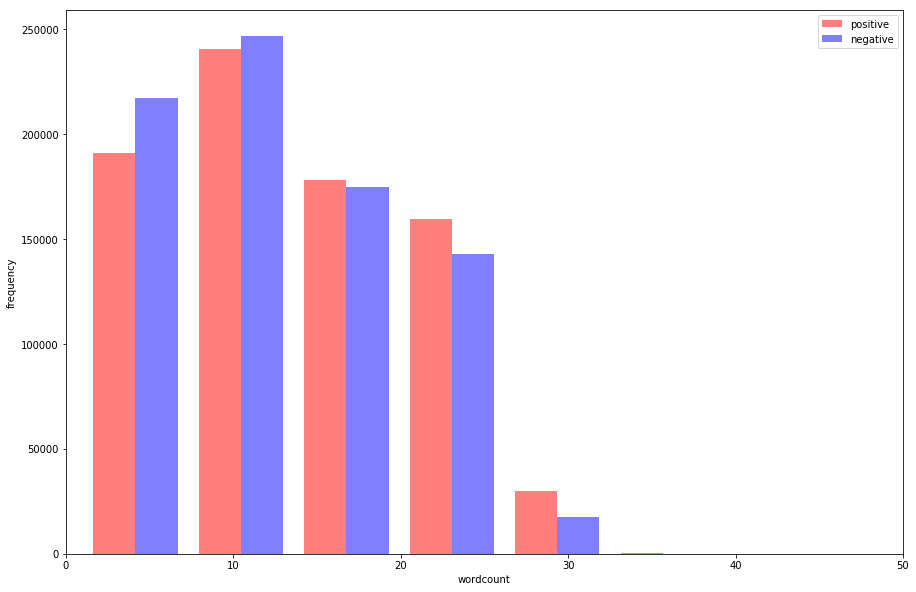

In [492]:
#We will plot the word count and the sentiment of the text to get the distribution

x=data['wordcount'][data.label==0]
y=data['wordcount'][data.label==4]

plt.figure(figsize=(15,10))
plt.xlim(0,50)
plt.xlabel('wordcount')
plt.ylabel('frequency')
g = plt.hist([x, y], color=['r','b'], alpha=0.5, label=['positive','negative'])
plt.legend(loc='upper right')


In [493]:
#Now lets find the most common word being used in the tweet text

all_words = []
for text in list(data['text']):
    words = text.split()
    for word in words:
        all_words.append(word.lower())

all_words = nltk.FreqDist(all_words)
print(all_words.most_common(15))

[('i', 746635), ('to', 560313), ('the', 518734), ('a', 376421), ('my', 312846), ('and', 295675), ('you', 237765), ('is', 231086), ('for', 214051), ('in', 209960), ('it', 191053), ('of', 182597), ('on', 161592), ('so', 145770), ('have', 143295)]


In [495]:
def processTweet(tweet):
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)
    # To lowercase
    tweet = tweet.lower()
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ')
    return tweet

data['cleaned_message'] = data['text'].apply(processTweet)
data.head(5)

,label,text,wordcount,cleaned_message
0,0,is upset that he can't update his Facebook by ...,21,is upset that he can't update his facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...,18,i dived many times for the ball. managed to sa...
2,0,my whole body feels itchy and like its on fire,10,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all....",21,"no, it's not behaving at all. i'm mad. why am ..."
4,0,@Kwesidei not the whole crew,5,not the whole crew


In [510]:
def handle_negations(text):
    all_words_neg = []
    negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
    neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], text)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    words = letters_only.split()
    for word in words:
        all_words_neg.append(word.lower())
    return ' '.join(all_words_neg)

#print(handle_negations(data.cleaned_message[0]))

data['cleaned_message'] = data['cleaned_message'].apply(handle_negations)

data.head(10)
    

,label,text,wordcount,cleaned_message
0,0,is upset that he can't update his Facebook by ...,21,is upset that he can not update his facebook b...
1,0,@Kenichan I dived many times for the ball. Man...,18,i dived many times for the ball managed to sav...
2,0,my whole body feels itchy and like its on fire,10,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all....",21,no it s not behaving at all i m mad why am i h...
4,0,@Kwesidei not the whole crew,5,not the whole crew
5,0,Need a hug,3,need a hug
6,0,@LOLTrish hey long time no see! Yes.. Rains a...,22,hey long time no see yes rains a bit only a bi...
7,0,@Tatiana_K nope they didn't have it,6,nope they did not have it
8,0,@twittera que me muera ?,5,que me muera
9,0,spring break in plain city... it's snowing,7,spring break in plain city it s snowing


In [563]:
clean_df = pd.DataFrame()
clean_df['text'] = data.cleaned_message

def change_label(label):
    if (label == 4):
        return 1
    else:
        return 0

clean_df['target'] = data['label'].apply(change_label)

clean_df.tail()

,text,target
1599994,just woke up having no school is the best feel...,1
1599995,thewdb com very cool to hear old walt intervie...,1
1599996,are you ready for your mojo makeover ask me fo...,1
1599997,happy th birthday to my boo of alll time tupac...,1
1599998,happy charitytuesday,1


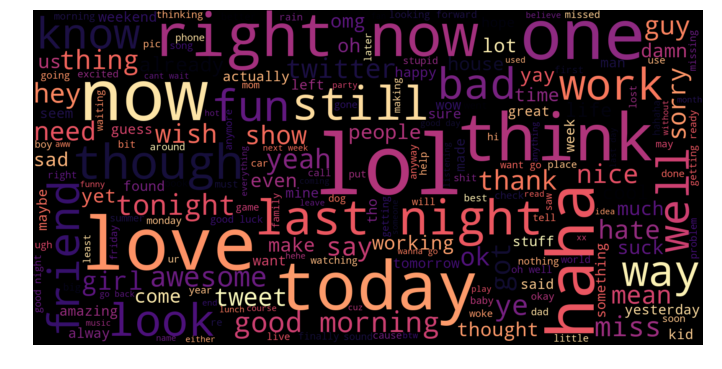

In [530]:
tweets = clean_df
t_string = []
for t in tweets.text:
    t_string.append(t)
t_string = pd.Series(t_string).str.cat(sep=' ')

from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(t_string) 
plt.figure(figsize=(12,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

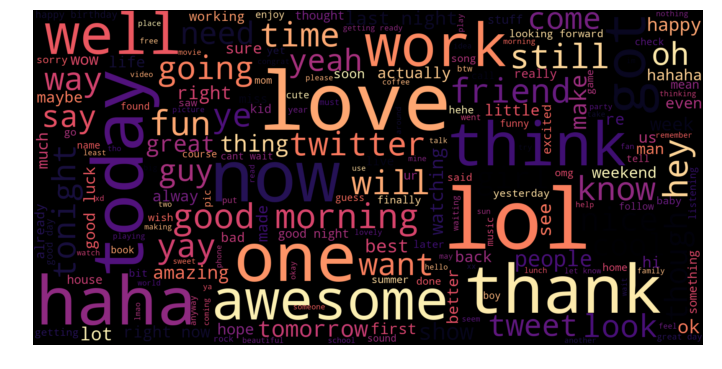

In [528]:
pos_tweets = clean_df[clean_df.target == 1]
pos_string = []
for t in pos_tweets.text:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')

from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(pos_string) 
plt.figure(figsize=(12,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

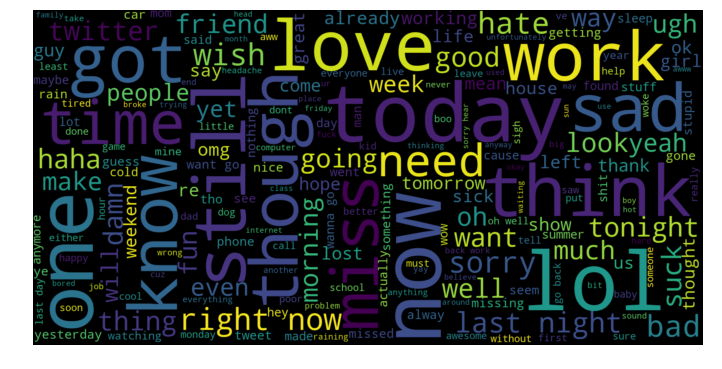

In [524]:
#Plot for words in negative tweets
neg_tweets = clean_df[clean_df.target == 0]
neg_string = []
for t in neg_tweets.text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [531]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer()
cvec.fit(clean_df.text)

len(cvec.get_feature_names())

271249

In [564]:
neg_doc_matrix = cvec.transform(clean_df[clean_df.target == 0].text)
pos_doc_matrix = cvec.transform(clean_df[clean_df.target == 1].text)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()

In [581]:
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']

term_freq_df.head()

,negative,positive,total
aa,123,70,193
aaa,70,35,105
aaaa,30,20,50
aaaaa,22,9,31
aaaaaa,13,9,22


In [583]:
#Top 10 Stop Words

term_freq_df.sort_values(by='total', ascending=False).iloc[:10]
my_stop_words = frozenset(list(term_freq_df.sort_values(by='total', ascending=False).iloc[:10].index))

In [584]:
x = clean_df.text
y = clean_df.target
from sklearn.model_selection import train_test_split
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)


In [586]:
#BaseLine model

from textblob import TextBlob
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
tbresult = [TextBlob(i).sentiment.polarity for i in x_validation]
tbpred = [0 if n < 0 else 1 for n in tbresult]
conmat = np.array(confusion_matrix(y_validation, tbpred, labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['positive', 'negative'],
                         columns=['predicted_positive','predicted_negative'])
print ("Accuracy Score: " + str(accuracy_score(y_validation, tbpred)*100))
print ("-"*80)
print ("Confusion Matrix\n")
print (confusion)
print ("-"*80)
print ("Classification Report\n")
print (classification_report(y_validation, tbpred))

Accuracy Score: 61.106249999999996
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_positive  predicted_negative
positive                7112                 780
negative                5443                2665
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

           0       0.77      0.33      0.46      8108
           1       0.57      0.90      0.70      7892

   micro avg       0.61      0.61      0.61     16000
   macro avg       0.67      0.61      0.58     16000
weighted avg       0.67      0.61      0.58     16000



In [588]:
#Bag of Word Approach
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    classifier = pipeline.fit(x_train, y_train)
    y_pred = classifier.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

cvec = CountVectorizer()
lr = LogisticRegression()
n_features = np.arange(10000,100001,10000)
def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print ("Validation result for feature: " + str(n))
        nfeature_accuracy = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy))
    return result


In [589]:
print ("Result for unigram without stop words\n")
result_unigram_withoutstopwords = nfeature_accuracy_checker(stop_words='english')
print ("Result for unigram with stop words\n")
result_unigram_withstopwords = nfeature_accuracy_checker()
print ("Result for unigram with top 10 stop words\n")
result_unigram_withtop10stopwords = nfeature_accuracy_checker(stop_words=my_stop_words)

Result for unigram without stop words

Validation result for feature: 10000
Validation result for feature: 20000
Validation result for feature: 30000
Validation result for feature: 40000
Validation result for feature: 50000
Validation result for feature: 60000
Validation result for feature: 70000
Validation result for feature: 80000
Validation result for feature: 90000
Validation result for feature: 100000
Result for unigram with stop words

Validation result for feature: 10000
Validation result for feature: 20000
Validation result for feature: 30000
Validation result for feature: 40000
Validation result for feature: 50000
Validation result for feature: 60000
Validation result for feature: 70000
Validation result for feature: 80000
Validation result for feature: 90000
Validation result for feature: 100000
Result for unigram with top 10 stop words

Validation result for feature: 10000
Validation result for feature: 20000
Validation result for feature: 30000
Validation result for feature

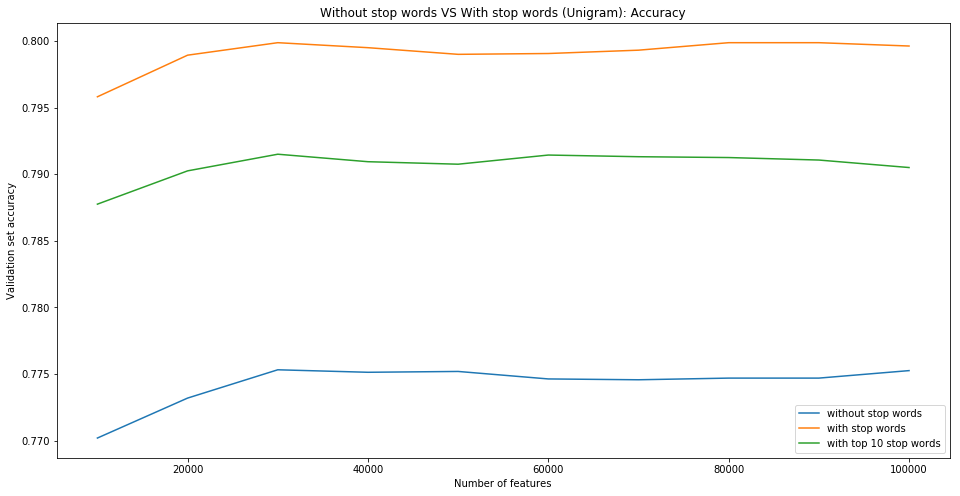

In [593]:
nfeatures_plot_ug = pd.DataFrame(result_unigram_withoutstopwords,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_ug_wsw = pd.DataFrame(result_unigram_withstopwords,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_ug_w10sw = pd.DataFrame(result_unigram_withtop10stopwords,columns=['nfeatures','validation_accuracy'])
plt.figure(figsize=(16,8))
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='without stop words')
plt.plot(nfeatures_plot_ug_wsw.nfeatures, nfeatures_plot_ug_wsw.validation_accuracy,label='with stop words')
plt.plot(nfeatures_plot_ug_w10sw.nfeatures, nfeatures_plot_ug_w10sw.validation_accuracy,label='with top 10 stop words')
plt.title("Without stop words VS With stop words (Unigram): Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [594]:
print ("Result for bigram without stop words\n")
result_bigram_withoutstopwords = nfeature_accuracy_checker(stop_words='english',ngram_range=(1, 2))
print ("Result for bigram with stop words\n")
result_bigram_withstopwords = nfeature_accuracy_checker(ngram_range=(1, 2))
print ("Result for bigram with top 10 stop words\n")
result_bigram_withtop10stopwords = nfeature_accuracy_checker(stop_words=my_stop_words,ngram_range=(1, 2))

Result for bigram without stop words

Validation result for feature: 10000
Validation result for feature: 20000
Validation result for feature: 30000
Validation result for feature: 40000
Validation result for feature: 50000
Validation result for feature: 60000
Validation result for feature: 70000
Validation result for feature: 80000
Validation result for feature: 90000
Validation result for feature: 100000
Result for bigram with stop words

Validation result for feature: 10000
Validation result for feature: 20000
Validation result for feature: 30000
Validation result for feature: 40000
Validation result for feature: 50000
Validation result for feature: 60000
Validation result for feature: 70000
Validation result for feature: 80000
Validation result for feature: 90000
Validation result for feature: 100000
Result for bigram with top 10 stop words

Validation result for feature: 10000
Validation result for feature: 20000
Validation result for feature: 30000
Validation result for feature: 4

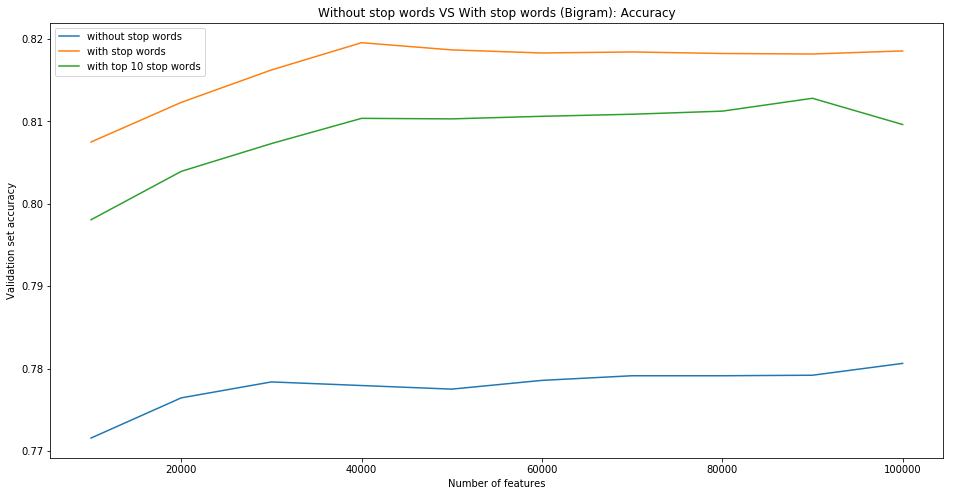

In [596]:
nfeatures_plot_bg = pd.DataFrame(result_bigram_withoutstopwords,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_bg_wsw = pd.DataFrame(result_bigram_withstopwords,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_bg_w10sw = pd.DataFrame(result_bigram_withtop10stopwords,columns=['nfeatures','validation_accuracy'])
plt.figure(figsize=(16,8))
plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy, label='without stop words')
plt.plot(nfeatures_plot_bg_wsw.nfeatures, nfeatures_plot_bg_wsw.validation_accuracy,label='with stop words')
plt.plot(nfeatures_plot_bg_w10sw.nfeatures, nfeatures_plot_bg_w10sw.validation_accuracy,label='with top 10 stop words')
plt.title("Without stop words VS With stop words (Bigram): Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [597]:
print ("Result for trigram without stop words\n")
result_trigram_withoutstopwords = nfeature_accuracy_checker(stop_words='english',ngram_range=(1, 3))
print ("Result for trigram with stop words\n")
result_trigram_withstopwords = nfeature_accuracy_checker(ngram_range=(1, 3))
print ("Result for trigram with top 10 stop words\n")
result_trigram_withtop10stopwords = nfeature_accuracy_checker(stop_words=my_stop_words,ngram_range=(1, 3))

Result for trigram without stop words

Validation result for feature: 10000
Validation result for feature: 20000
Validation result for feature: 30000
Validation result for feature: 40000
Validation result for feature: 50000
Validation result for feature: 60000
Validation result for feature: 70000
Validation result for feature: 80000
Validation result for feature: 90000
Validation result for feature: 100000
Result for trigram with stop words

Validation result for feature: 10000
Validation result for feature: 20000
Validation result for feature: 30000
Validation result for feature: 40000
Validation result for feature: 50000
Validation result for feature: 60000
Validation result for feature: 70000
Validation result for feature: 80000
Validation result for feature: 90000
Validation result for feature: 100000
Result for trigram with top 10 stop words

Validation result for feature: 10000
Validation result for feature: 20000
Validation result for feature: 30000
Validation result for feature

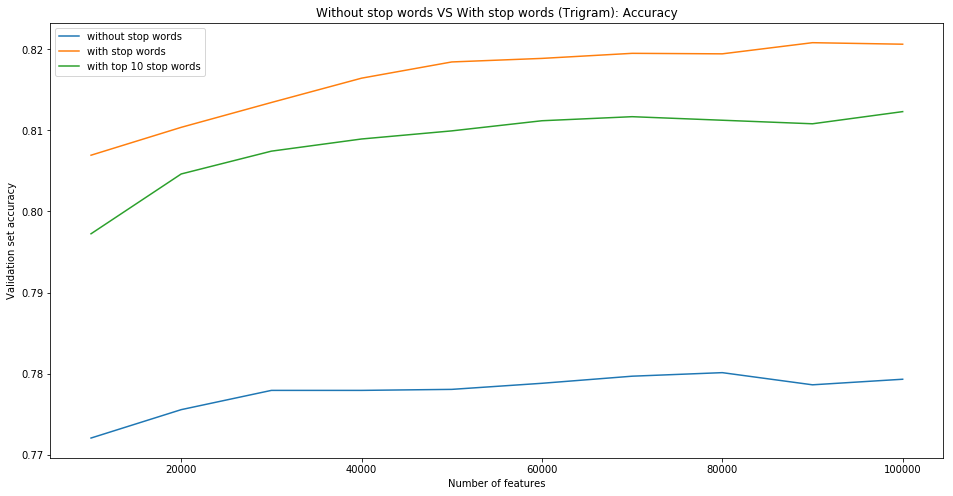

In [599]:
nfeatures_plot_tg = pd.DataFrame(result_trigram_withoutstopwords,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_tg_wsw = pd.DataFrame(result_trigram_withstopwords,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_tg_w10sw = pd.DataFrame(result_trigram_withtop10stopwords,columns=['nfeatures','validation_accuracy'])
plt.figure(figsize=(16,8))
plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy, label='without stop words')
plt.plot(nfeatures_plot_tg_wsw.nfeatures, nfeatures_plot_tg_wsw.validation_accuracy,label='with stop words')
plt.plot(nfeatures_plot_tg_w10sw.nfeatures, nfeatures_plot_tg_w10sw.validation_accuracy,label='with top 10 stop words')
plt.title("Without stop words VS With stop words (Trigram): Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

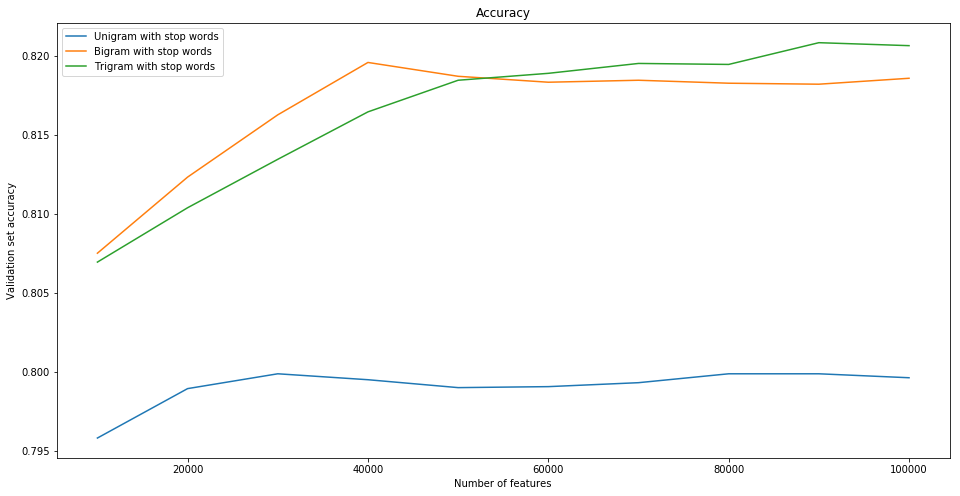

In [602]:
#Comparing unigram bigram and trigram
nfeatures_plot_ug_wsw = pd.DataFrame(result_unigram_withstopwords,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_bg_wsw = pd.DataFrame(result_bigram_withstopwords,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_tg_wsw = pd.DataFrame(result_trigram_withstopwords,columns=['nfeatures','validation_accuracy'])
plt.figure(figsize=(16,8))
plt.plot(nfeatures_plot_ug_wsw.nfeatures, nfeatures_plot_ug_wsw.validation_accuracy,label='Unigram with stop words')
plt.plot(nfeatures_plot_bg_wsw.nfeatures, nfeatures_plot_bg_wsw.validation_accuracy,label='Bigram with stop words')
plt.plot(nfeatures_plot_tg_wsw.nfeatures, nfeatures_plot_tg_wsw.validation_accuracy,label='Trigram with stop words')
plt.title("Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()